# Natural Disaster - NLP Use-Case: Binary Classification of Tweets

### Data Set:

The data set was downloaded from https://www.kaggle.com/competitions/nlp-getting-started/data

### Objectives

- Your clients would like to classify tweets as either being about a real disaster or not.
- They would like you to use the simplest possible model that “gets the job done” and achieves sufficiently high accuracy (a number they don’t want to define). As well, they value understanding how the model arrived at its classification, if possible.
- You will train and evaluate 3 learning algorithms of increasing complexity.
- Each learning algorithm will require preprocessing the text data differently, which you will have to implement yourself.
- Your goal is to present to your clients options that balance explainable models with performance.

### Libraries Import

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from collections import Counter
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                            confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc)

import warnings
warnings.filterwarnings("ignore")
nltk.download('omw-1.4')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\musma\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data Loading and Basic Understanding

The train.csv and test.csv files are downloaded from the url provided in the data set section above

In [91]:
df_train = pd.read_csv(r'data_set\train.csv')
df_test = pd.read_csv(r'data_set\test.csv')

print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [92]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [93]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test file on the Kaggle is for the internal validation purpose and the the labels are not provided. Therefore, it can't be used for the testing purpose in our case. I will create a train test split of the data in train.csv.

The data set contains keyword and location columns as well but they wont' be used in the modeling for this exercise.

### Some important functions for processing and visualizations
should ideally be written in separate .py file

In [94]:
def get_most_common_words(data, text_col, by, count):
    common_words = {}    
    for val in data[by].unique():
        df = data[data[by] == val]
        common_words[f"{by} = {val}"] = Counter(" ".join(df[text_col]).split()).most_common(count)
    return common_words


def process(text, lemmatize=True):
    stop_words = nltk.corpus.stopwords.words("english")
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    tokens = text.split()
    tokens = [t.strip().lower() for t in tokens if t.strip().lower() not in stop_words]
    tokens = [nltk.stem.wordnet.WordNetLemmatizer().lemmatize(t) for t in tokens]
    
    return ' '.join(tokens)


In [95]:
def stacked_barplot(data, predictor, target):    
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()
    
def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  #
        sharex=True,  
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  

def display_word_cloud_by_target(data, text_col, target):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    target_uniq = data[target].unique()

    axs[0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    axs[0].imshow(WordCloud().generate(' '.join(data[data[target] == target_uniq[0]][text_col])))


    axs[1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    axs[1].imshow(WordCloud().generate(' '.join(data[data[target] == target_uniq[1]][text_col])))   

    plt.tight_layout()
    plt.show()

## Exploratory Data Analysis

Creating a deep copy of the input data for processing.

In [96]:
data = df_train.copy()

In [97]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [98]:
data.describe(exclude='number')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [99]:
data.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [100]:
data.duplicated().sum()

0

No duplicates are found in the data set

In [101]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

There are som missing values in the keyword and location column but as we are not going to use them in this exercise, we do not need to consider/treat them.

In [102]:
data.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

The class seems to be fairly distributed. Yet, the imapct of using re-sampling techniques could have been studied. However, as the purpose of this exercise is to evalaute the basics and final accuracy/metric is not of much concern, I am going to carry on without application of any re-sampling technique.

To do some basic exploratory analysis, let's create two features: lenght of tweet in characters, and length of tweet in words. The word lenght of tweets is calcualted by splitting over white space. 

In [103]:
data['tweet_len'] = data.text.apply(len)
data['tweet_words_len'] = data.text.apply(lambda x: len(x.split(' ')))

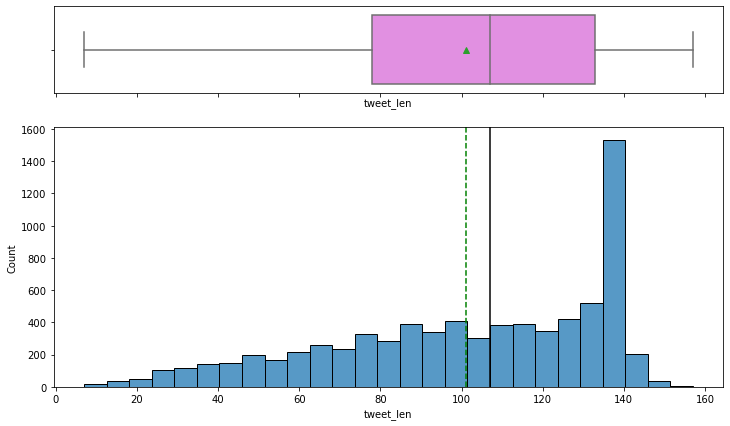

In [104]:
histogram_boxplot(data, 'tweet_len')

The character lenght of tweet is left skewed with more tweets having approximate 140 characters.

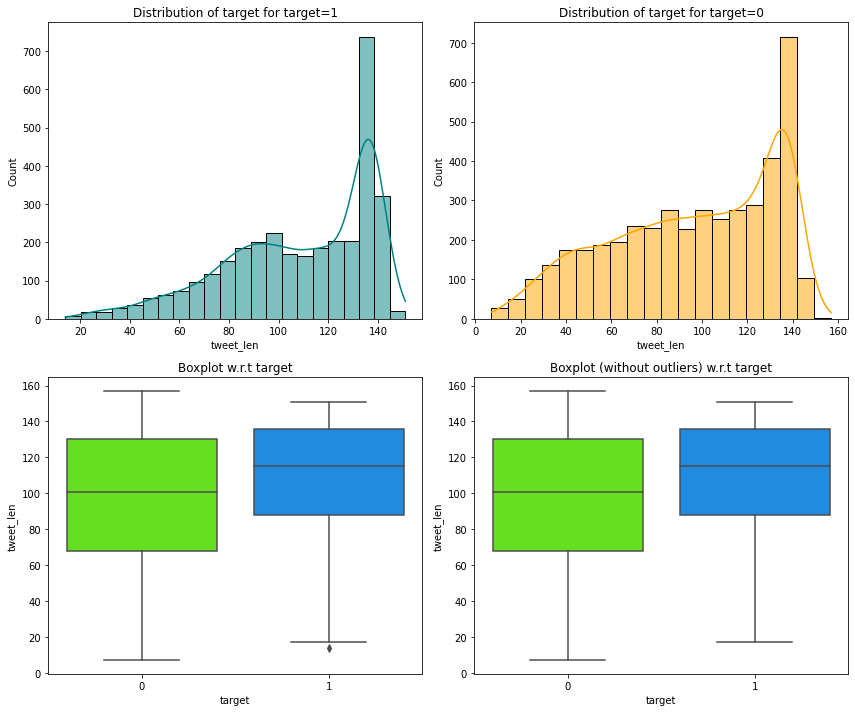

In [105]:
distribution_plot_wrt_target(data, 'tweet_len', 'target')

The above visual shows that the number of characters in the tweets mentioning disaster are more than the otherwise tweets. Let's see if the same pattern can be observed in the words length of the tweets.

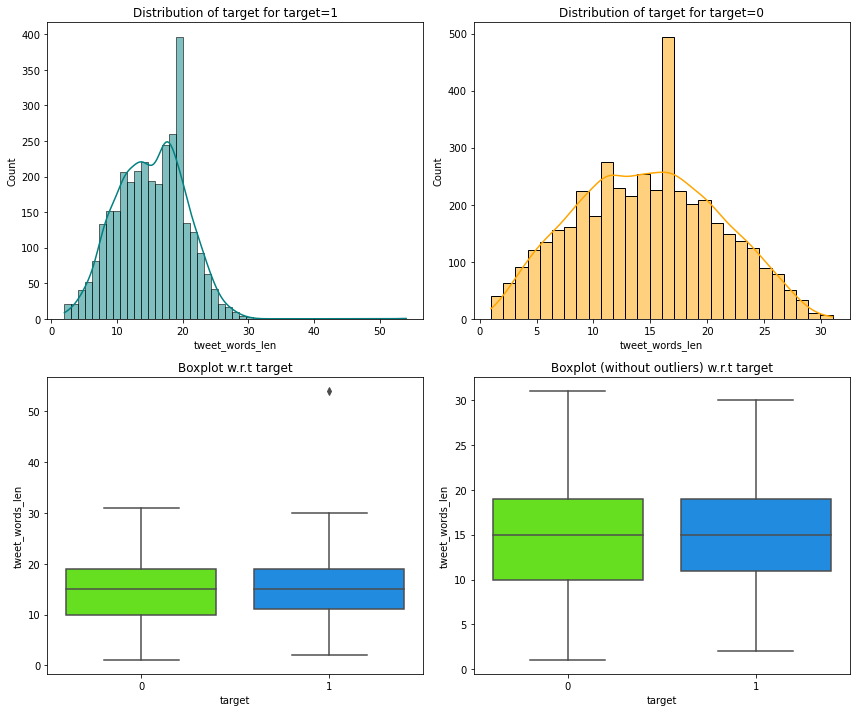

In [106]:
distribution_plot_wrt_target(data, 'tweet_words_len', 'target')

Number of words in tweets mentioning disaster and otherwise are similar. Let's find out top 10 words in tweets of each class.

In [107]:
get_most_common_words(data, 'text', 'target', 10)

{'target = 1': [('the', 1051),
  ('in', 1037),
  ('of', 888),
  ('a', 730),
  ('to', 706),
  ('and', 462),
  ('-', 389),
  ('on', 386),
  ('for', 368),
  ('is', 302)],
 'target = 0': [('the', 1524),
  ('a', 1115),
  ('to', 1099),
  ('I', 938),
  ('and', 840),
  ('of', 834),
  ('in', 720),
  ('you', 529),
  ('is', 512),
  ('for', 452)]}

We can observe that the top 10 words are very common articles, prepositions, etc. Let's apply claeaning process (stop words removal and lemmatization) and see the top words again.

In [108]:
data['processed_text'] = data.text.apply(process)

In [109]:
get_most_common_words(data, 'processed_text', 'target', 10)

{'target = 1': [('fire', 262),
  ('news', 136),
  ('via', 121),
  ('disaster', 117),
  ('california', 115),
  ('suicide', 110),
  ('police', 107),
  ('people', 106),
  ('amp', 106),
  ('family', 105)],
 'target = 0': [('like', 255),
  ('im', 243),
  ('amp', 192),
  ('get', 185),
  ('new', 168),
  ('u', 142),
  ('dont', 141),
  ('one', 136),
  ('body', 116),
  ('time', 103)]}

Now, we have more useful information in these words. Let's visualize this in form of word cloud.

Now, we have got a fair understanding of our data set. Let's next prepare for modeling. First of all, we split the data into train and test sets. Remember, we have already applied the cleaning process and it is the processed_text that we will use as input. This is appropriate even in case of Task 3 as the word embeddings can't use the context in a sentence.

## Data Sampling

Next, we spit the data into train and test sets. Remember, that we haven't applied any transformation that could cause DATA LEAKAGE. The only processing applied are stop words removal and lemmatization which are not learned from the data rather are applied based on existing knowledge.

In [110]:
X = data['processed_text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"The Shape of data: {data.shape}")
print(f"The Shape of X_train: {X_train.shape}")
print(f"The Shape of X_test: {X_test.shape}")

print(f"The class distribution of data:\n{y.value_counts(normalize=True)}")
print(f"The class distribution of train data:\n{y_train.value_counts(normalize=True)}")
print(f"The class distribution of test data:\n{y_test.value_counts(normalize=True)}")

The Shape of data: (7613, 8)
The Shape of X_train: (6090,)
The Shape of X_test: (1523,)
The class distribution of data:
0    0.57034
1    0.42966
Name: target, dtype: float64
The class distribution of train data:
0    0.570279
1    0.429721
Name: target, dtype: float64
The class distribution of test data:
0    0.570584
1    0.429416
Name: target, dtype: float64


We can see that class distribution is even in train and test sets. 

Before going further, let's take some important decisions and create helper functions.
1. We are going to build models using sklearn's default implmentations of Logistic Regression, SVM Classifier, SGD classifer, Decision Tree Classfier, and XGB Classfier. The choice is made to obtain models using varaious traditional approaches.
2. The problem we are dealing with is a binary classification problem and we have not been provided any clear evaluation criteria. As there is slight class imbalance, we will not rely only on accuracy and comapre the performance of classifers using accuracy, precision, recall, and f1 score.
3. Write functions for ploting performance curves (confusion matrix, roc auc curve, and precision recall curver)

In [111]:
models = [LogisticRegression(), SVC(gamma='auto'), SGDClassifier() ,DecisionTreeClassifier(), XGBClassifier()]

In [112]:
def evaluate_performance(model, features, target):
    pred = model.predict(features)
    acc = accuracy_score(target, pred)  
    recall = recall_score(target, pred)  
    precision = precision_score(target, pred)  
    f1 = f1_score(target, pred)  

    return acc, recall, precision, f1

def compare_models_performance(models: list, features, target):
    df_perf = pd.DataFrame(columns = ["Model", "Accuracy", "Recall", "Precision", "F1"])
    for model in models:
        acc, recall, precision, f1 = evaluate_performance(model, features, target)        
        df_perf = df_perf.append({"Model":str(model).split('(')[0], "Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,}, ignore_index=True)

    return df_perf

In [113]:
def plot_conf_matrix(model, predictors, target):    
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [114]:
def plot_prec_recall_and_roc_auc(model, predictors, target):   
    try: 
        y_pred_prob = model.predict_proba(predictors)
        target_array = pd.get_dummies(target, drop_first=False).values
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        for i in range(len(target.unique())):
            fpr, tpr, thresholds = roc_curve(target_array[:,i], y_pred_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(target.unique()[i], auc(fpr, tpr)))
            ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
            ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                    xlabel='False Positive Rate', 
                    ylabel="True Positive Rate (Recall)", 
                    title="Receiver operating characteristic")
            ax[0].legend(loc="lower right")
            ax[0].grid(True)

        for i in range(len(target.unique())):
            precision, recall, thresholds = precision_recall_curve(target_array[:,i], y_pred_prob[:,i])
            ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(target.unique()[i],auc(recall, precision)))
            ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
                    ylabel="Precision", title="Precision-Recall curve")
            ax[1].legend(loc="best")
            ax[1].grid(True)
    except:
        print(f'no display for {str(model)}')
    finally:
        plt.show()

## Task 1: Bag of Words (bow)  

Bag of Words (BOW) simply rely on the count of each vocabulary word in a given sentence. We can create a BOW using the following sklearn code. We have built a BOW using the vocabulary of size 1000.

It is important no note that the BOW is learned and appleid (fit_transform) using train data while the same learnign (only transform) is applied to the test data.

In [115]:
bow_transformer = CountVectorizer(max_features=1000)

X_train_bow = bow_transformer.fit_transform(X_train)
X_test_bow = bow_transformer.transform(X_test)

print(X_train_bow.shape)
print(X_test_bow.shape)

(6090, 1000)
(1523, 1000)


Let's train each model using the BOW trainedd features.

In [116]:
for model in models:
    model.fit(X_train_bow, y_train)

Let's compare the performance metrics for each model on train and test set respectively.

In [117]:
compare_models_performance(models, X_train_bow, y_train)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.849097,0.763852,0.86913,0.813097
1,SVC,0.570936,0.001528,1.0,0.003052
2,SGDClassifier,0.861412,0.790982,0.874525,0.830658
3,DecisionTreeClassifier,0.973892,0.948414,0.990423,0.968963
4,XGBClassifier,0.822824,0.670233,0.890355,0.76477


In [118]:
compare_models_performance(models, X_test_bow, y_test)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.806303,0.720183,0.80789,0.76152
1,SVC,0.570584,0.0,0.0,0.0
2,SGDClassifier,0.801707,0.730887,0.791391,0.759936
3,DecisionTreeClassifier,0.753119,0.703364,0.716511,0.709877
4,XGBClassifier,0.795798,0.66055,0.829175,0.735319


We can see that SGDClassfier (with default parameters) has outperformed other classifers (with default parameters). The model generalizes reasonably well and not overfitting. The SVM on the other hand has performed badly.

=============================== displaying results for LogisticRegression ================================


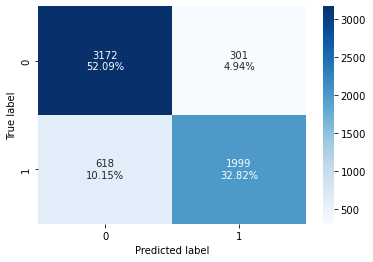

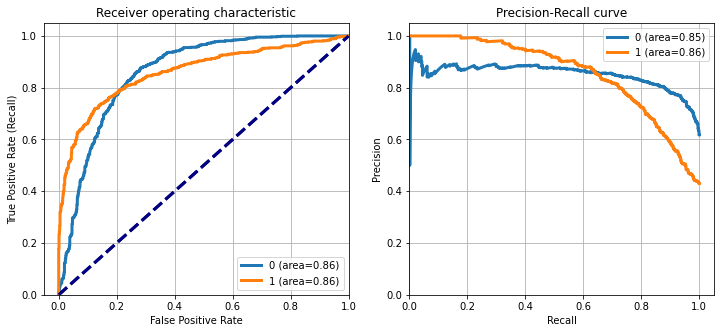

=============================== displaying results for SVC ================================
no display for SVC(gamma='auto')


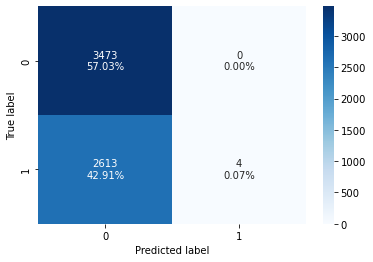

=============================== displaying results for SGDClassifier ================================
no display for SGDClassifier()


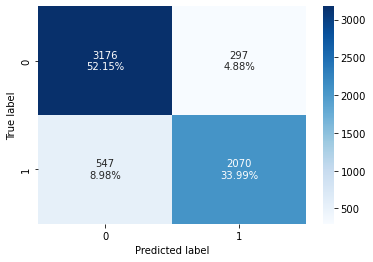

=============================== displaying results for DecisionTreeClassifier ================================


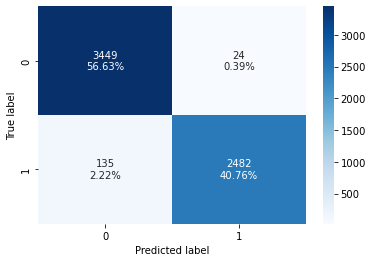

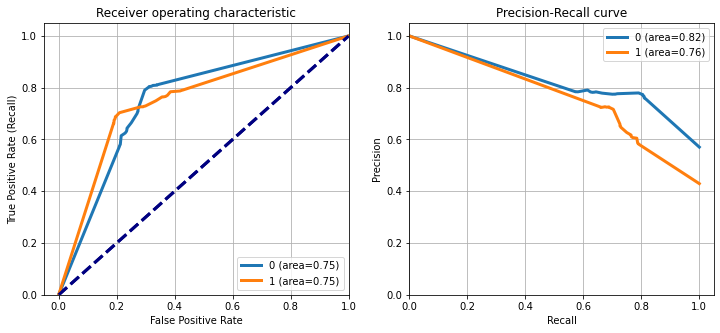

=============================== displaying results for XGBClassifier ================================


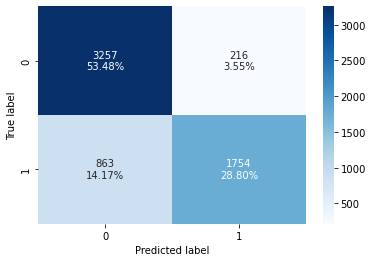

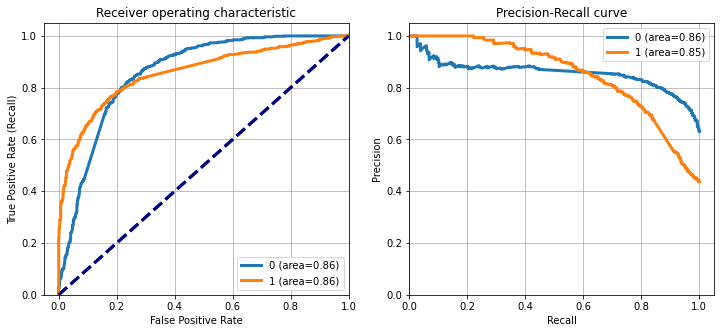

In [119]:
for model in models:
    print(f"=============================== displaying results for {str(model).split('(')[0]} ================================")
    plot_conf_matrix(model, X_train_bow, y_train)
    plot_prec_recall_and_roc_auc(model, X_test_bow, y_test)

The above plots also show reasonable performance of the classifiers. The ROC AUC curve is nto available for SVM and SGD because they cannot predict the probabilities of the classes.

## Task 2: Feature generation and traditional ML model

The task 2 is to create features using TFIDF which has been a very popular approach in tradional NLP. This can also be achieved, in manner similar to BOW, using TFIDFVectorizer of sklearn. We use 1000 features, including unigrams and bigrams.

In [120]:
tfidf_transformer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

X_train_tf = tfidf_transformer.fit_transform(X_train)
X_test_tf = tfidf_transformer.transform(X_test)

print(X_train_tf.shape)
print(X_test_tf.shape)

(6090, 1000)
(1523, 1000)


We train the five models ....

In [121]:
for model in models:
    model.fit(X_train_tf, y_train)

In [122]:
compare_models_performance(models, X_train_tf, y_train)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.835468,0.737486,0.859688,0.793912
1,SVC,0.570279,0.0,0.0,0.0
2,SGDClassifier,0.842529,0.756592,0.860122,0.805042
3,DecisionTreeClassifier,0.971921,0.943065,0.991165,0.966517
4,XGBClassifier,0.856322,0.71303,0.937688,0.810072


In [123]:
compare_models_performance(models, X_test_tf, y_test)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.808273,0.712538,0.817544,0.761438
1,SVC,0.570584,0.0,0.0,0.0
2,SGDClassifier,0.799081,0.715596,0.795918,0.753623
3,DecisionTreeClassifier,0.757058,0.723242,0.714502,0.718845
4,XGBClassifier,0.790545,0.64526,0.829077,0.725709


Logistic Regression seems to be the winner in this case which is generalizing reasonably well. SVM is again not performing well.

=============================== displaying results for LogisticRegression ================================


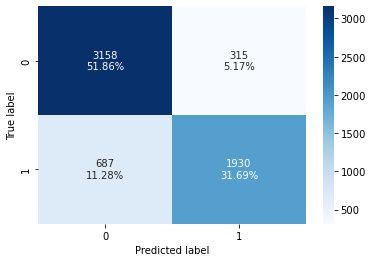

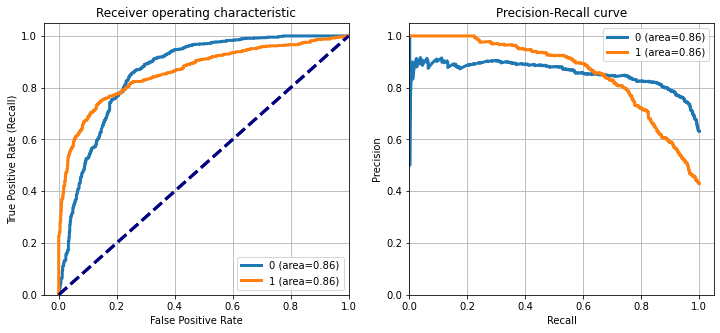

=============================== displaying results for SVC ================================
no display for SVC(gamma='auto')


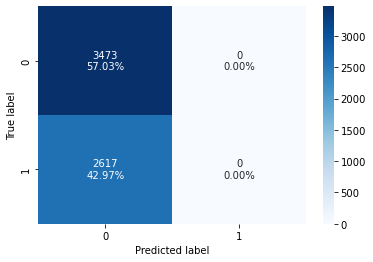

=============================== displaying results for SGDClassifier ================================
no display for SGDClassifier()


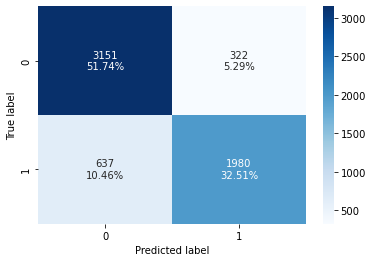

=============================== displaying results for DecisionTreeClassifier ================================


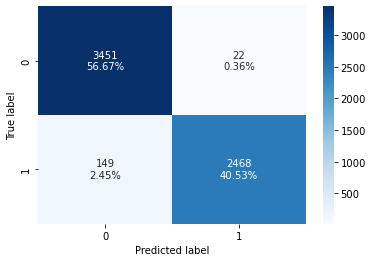

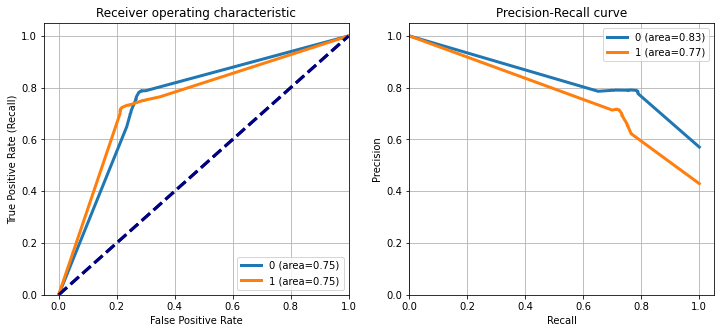

=============================== displaying results for XGBClassifier ================================


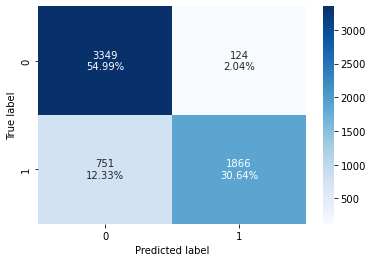

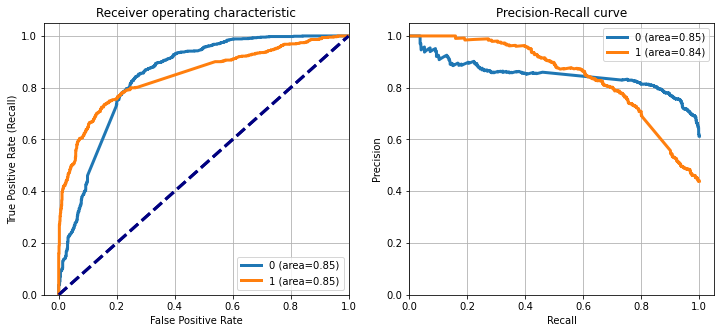

In [124]:
for model in models:
    print(f"=============================== displaying results for {str(model).split('(')[0]} ================================")
    plot_conf_matrix(model, X_train_tf, y_train)
    plot_prec_recall_and_roc_auc(model, X_test_tf, y_test)

The plots confirm the performance of the models.

## Task 3: Pre-trained word embeddings + linear classifier model

The word embeddings are learned usign a large corpus, however, in this exercise we will be using pretrainedd embeddings. The Glove Twitter embeddings are dwnloaded from https://nlp.stanford.edu/projects/glove/.


In [125]:
embeddings_dict = {}
with open("data_set\glove.twitter.27B\glove.twitter.27B.200d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

The 200 dimensional sentence embeddings are created using a naive approach of summing the embeddings of individual words using the follwoing function

In [126]:
def get_sentence_embeddings(sentence):
    sen_embedding = np.asanyarray([0.0]*200)
    for word in sentence.split():
        if word in embeddings_dict:
            sen_embedding += embeddings_dict[word]
    
    return sen_embedding

In [127]:
X_train_glove = X_train.apply(get_sentence_embeddings).apply(pd.Series)
X_test_glove = X_test.apply(get_sentence_embeddings).apply(pd.Series)

print(X_train_glove.shape)
print(X_test_glove.shape)

(6090, 200)
(1523, 200)


In [128]:
for model in models:
    model.fit(X_train_glove, y_train)

In [129]:
compare_models_performance(models, X_train_glove, y_train)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.811823,0.718762,0.821039,0.766504
1,SVC,0.949097,0.903324,0.976456,0.938468
2,SGDClassifier,0.736617,0.421093,0.925273,0.578782
3,DecisionTreeClassifier,0.986207,0.971723,0.996083,0.983752
4,XGBClassifier,0.986207,0.979366,0.98843,0.983877


In [130]:
compare_models_performance(models, X_test_glove, y_test)

,Model,Accuracy,Recall,Precision,F1
0,LogisticRegression,0.80499,0.724771,0.80203,0.761446
1,SVC,0.814183,0.701835,0.839122,0.764363
2,SGDClassifier,0.730794,0.428135,0.886076,0.57732
3,DecisionTreeClassifier,0.701248,0.655963,0.650986,0.653465
4,XGBClassifier,0.807617,0.740061,0.797364,0.767645


The DecisionTree and XGB are performing well on the training data but they are badly overfitting. The best solution, in this case too, is LogisticRegression.

=============================== displaying results for LogisticRegression ================================


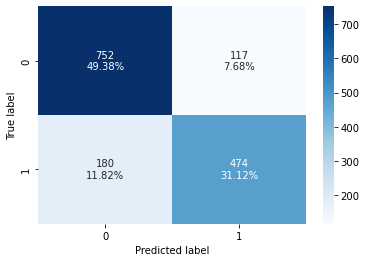

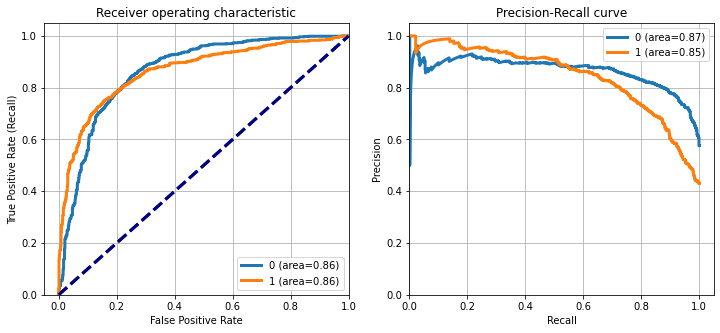

=============================== displaying results for SVC ================================
no display for SVC(gamma='auto')


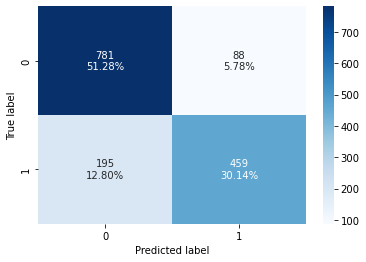

=============================== displaying results for SGDClassifier ================================
no display for SGDClassifier()


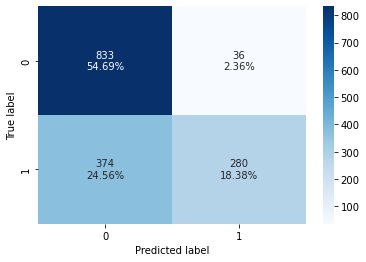

=============================== displaying results for DecisionTreeClassifier ================================


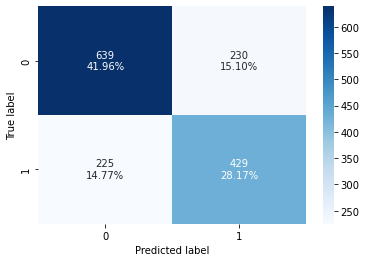

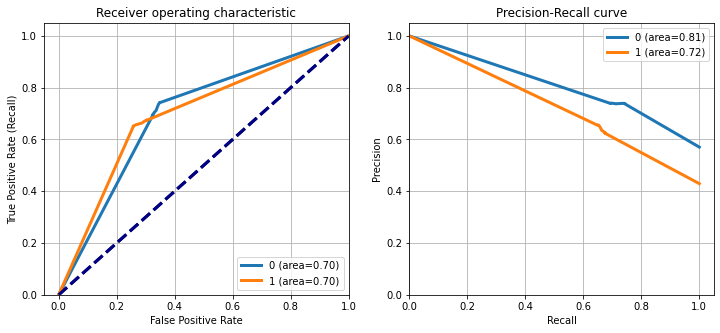

=============================== displaying results for XGBClassifier ================================


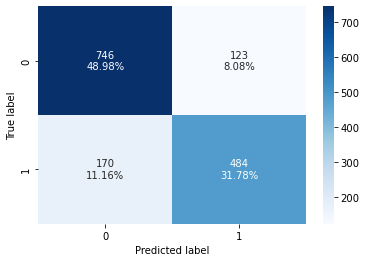

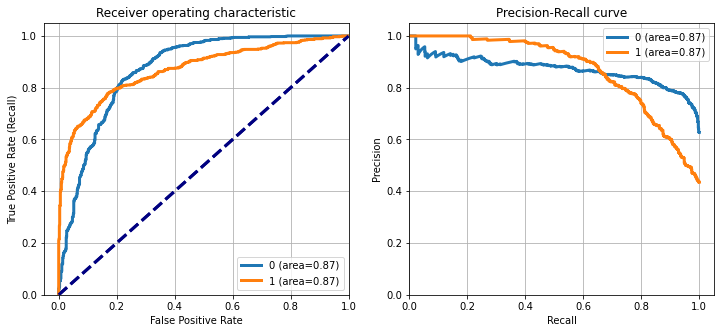

In [131]:
for model in models:
    print(f"=============================== displaying results for {str(model).split('(')[0]} ================================")
    plot_conf_matrix(model, X_test_glove, y_test)
    plot_prec_recall_and_roc_auc(model, X_test_glove, y_test)

## Task 4: Recommendation to the Clients

1. Tradional ML algorithms with basic NLP techniques could be used to calssify natural disaster tweets with reasonable accuracy/f1-score
2. The best performing model are the LogisticRegression and SGDClassifier in all cases. The model with BOW and TFIDF performed better than the one with Glove mebeddings. There are, however, some important constraints to this approach: a) the models were trained using deault hyperparameters and no tuning was performed. b) the feature generation process was very naive. c) class imbalace, even though slight, was not considered.
3. The models took more time training with Glove embeddings
4. There are more powerful approaches to NLP than the ones studied in this exercise.


### Thank You!